# UCI Wine Quality Dataset Analysis, Regression, Classification

## Dataset Description and Notebook Objectives

From [the UCI repository for this dataset](https://archive.ics.uci.edu/ml/datasets/wine+quality): "The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.). These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods."

The two datasets are provided in csv format. winequality-red.csv and winequality-white.csv are for red and white wines, respectively. They can be found through the UCI repository and are not included in this GitHub repository.

The fact that the classes are not balanced, and that the datasets are separated into red and white wines, provides some interesting possibilities for regression and classification tasks, with targets including:
- Quality (linear regression)
- Quality (tree regression)
- Quality (multi-class tree classification)
- Wine type (red or white, binary classification)

My experience with outlier/anomaly detection algorithms is limited (leaning towards nonexistent) so this may be an opportunity to explore such algorithms.

Also, the mention that it is not clear if "all input variables are relevant" opens up interesting possibilites for feature selection, feature engineering, and PCA.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## First Attempt

Let's look at what we've got and play around with it for a bit.

### Getting the Data

Let's load the data into dataframes and see what we have to work with. For now, let's keep the red and white wines separate until we better understand the underlying data.

In [2]:
# load data into dataframes
red_df = pd.read_csv('winequality-red.csv')
white_df = pd.read_csv('winequality-white.csv')

# number of rows and columns in datasets
print(red_df.shape)
print(white_df.shape)

(1599, 1)
(4898, 1)


Uh oh! That shape isn't right. We should have more than 1 column.

Mental note: We have 3x the rows in white_df. That's not a problem in itself, but we should be careful to know that our dataset is lopsided if we decide to merge the datasets (for example, when predicing classification by wine type).

A quick look at the csv shows us that the delimiter isn't a comma, it's a semicolon (Hey UCI, you know that CSV stands for "Comma Separated Values", right?).

Let's try that again with the correct delimiter.

In [3]:
# once more, with feeling
red_df = pd.read_csv('winequality-red.csv', delimiter=';')
white_df = pd.read_csv('winequality-white.csv', delimiter=';')
print(red_df.shape)
print(white_df.shape)

(1599, 12)
(4898, 12)


That's more like it. Let's take a look at our datasets.

### Exploratory Data Analysis (EDA)

#### First Look

Let's get a high-level overview of what we're working with.

In [4]:
red_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
white_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


The only value that jumps out is the density value of row 0 of white_df. I'm assuming the density values go from 0 to 1, and this value is greater than 1?

Let's come back to that. For now, we'll get some summaries.

In [6]:
red_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [7]:
white_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


Quite convenient that all of our values are numerical! And nice to see that there aren't any explicit null values either (although we still need to be wary of implicit nulls).

In [8]:
red_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [9]:
white_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


A few insights jump out here:
- All density values are around 0.99 (the absolute lowest being 0.98711). Perhaps normalizing this data will make it more valuable.
- There are no quality values below 3, and no values above 9. Vinho Verde never makes (relatively) garbage wine, but no perfect scores, either.
- Volatile acidity is likely a measure of variability, and fixed acidity likely acts as a "mean".
- Almost all variables have outliers (most commonly, the maximums).
- There are clear differences between white and red wines in a lot of the variables.

#### Basic Visualizations

Getting an image of the data provides more insight than just numbers (at least it does for our pitiful monkey brains).

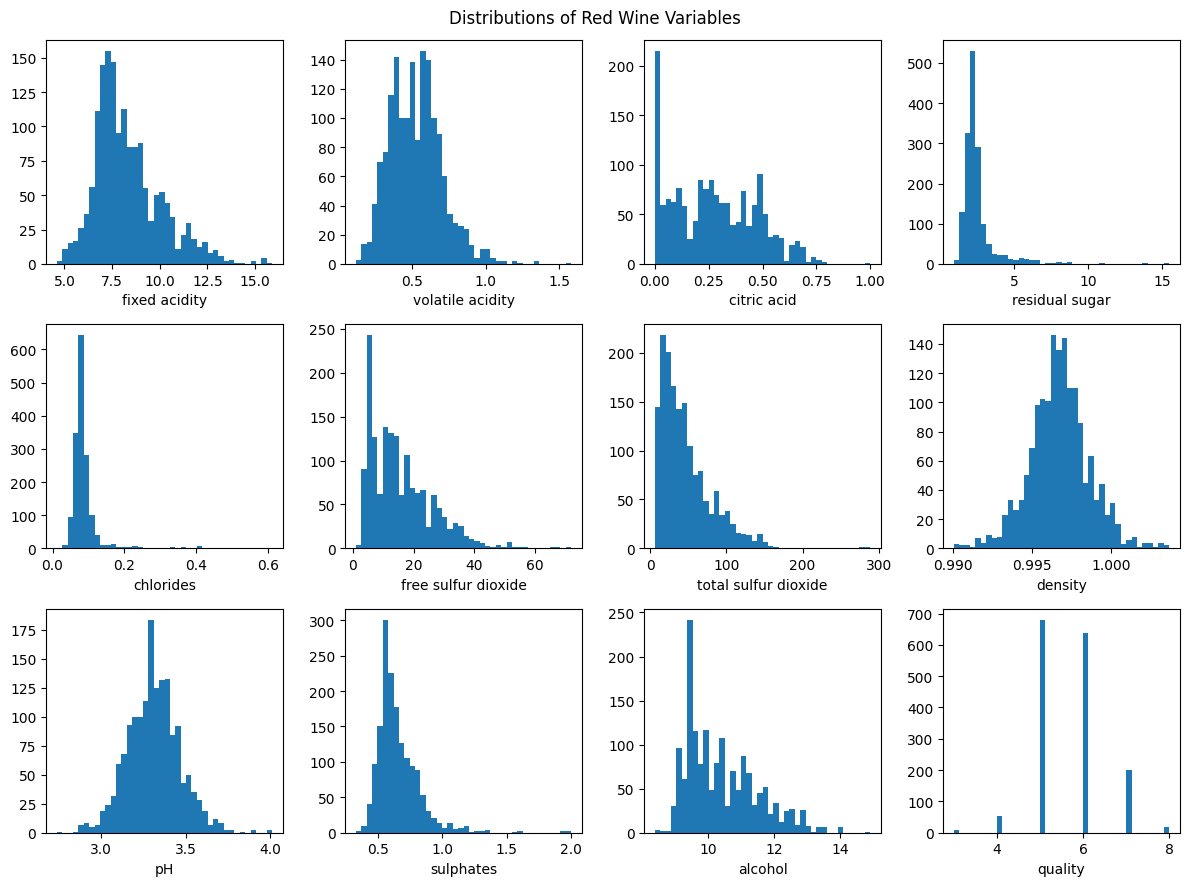

In [23]:
# prepare column names
red_col_names = red_df.columns

fig_red, axs_red = plt.subplots(3, 4, figsize=(12, 9))

# fill axes with distributions
for i in range(12):
    if i < 4:
        axs_red[0][i].hist(red_df[red_col_names[i]], bins=40)
        axs_red[0][i].set_xlabel(red_col_names[i])
    if 4 <= i < 8:
        axs_red[1][i-4].hist(red_df[red_col_names[i]], bins=40)
        axs_red[1][i-4].set_xlabel(red_col_names[i])
    if i >= 8:
        axs_red[2][i-8].hist(red_df[red_col_names[i]], bins=40)
        axs_red[2][i-8].set_xlabel(red_col_names[i])

fig_red.suptitle('Distributions of Red Wine Variables')
fig_red.tight_layout()

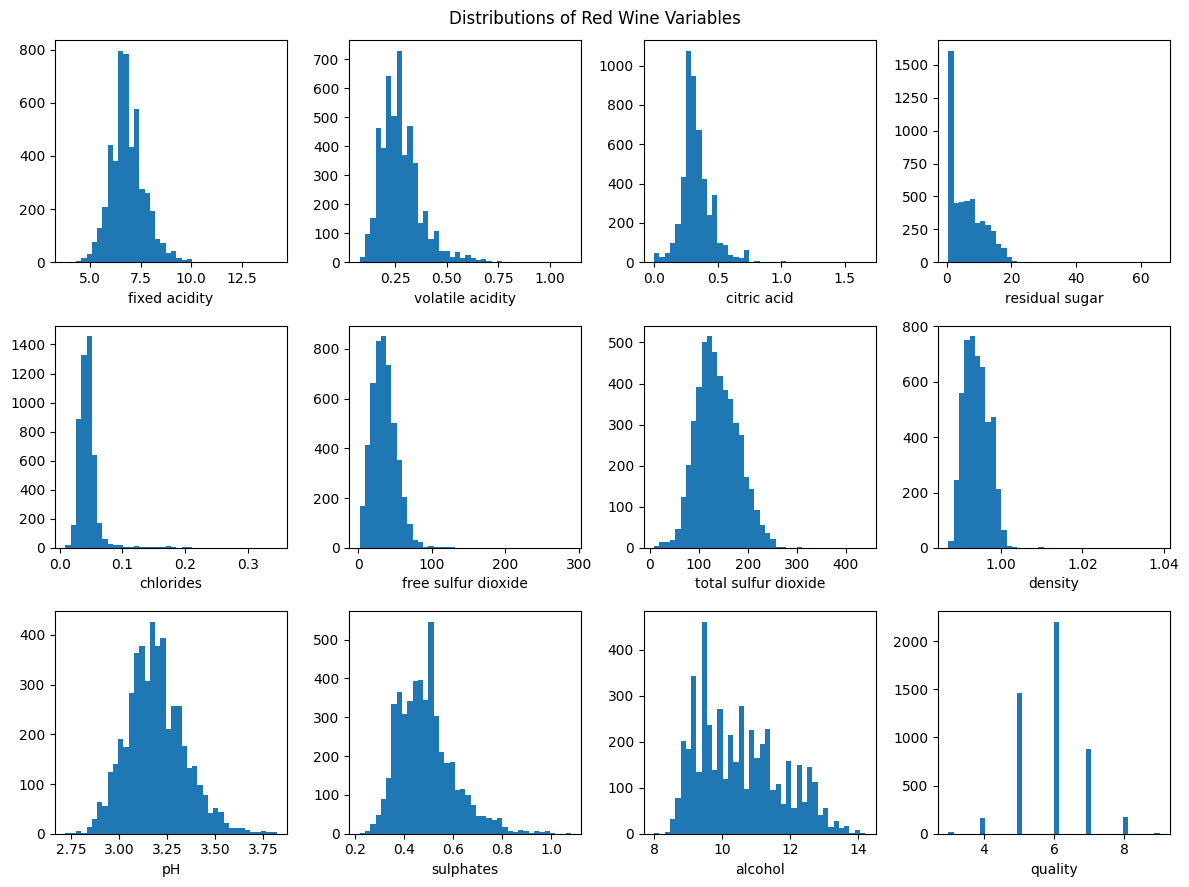

In [24]:
# prepare column names
white_col_names = white_df.columns

fig_white, axs_white = plt.subplots(3, 4, figsize=(12, 9))

# fill axes with distributions
for i in range(12):
    if i < 4:
        axs_white[0][i].hist(white_df[white_col_names[i]], bins=40)
        axs_white[0][i].set_xlabel(white_col_names[i])
    if 4 <= i < 8:
        axs_white[1][i-4].hist(white_df[white_col_names[i]], bins=40)
        axs_white[1][i-4].set_xlabel(white_col_names[i])
    if i >= 8:
        axs_white[2][i-8].hist(white_df[white_col_names[i]], bins=40)
        axs_white[2][i-8].set_xlabel(white_col_names[i])

fig_white.suptitle('Distributions of White Wine Variables')
fig_white.tight_layout()

A few more things become clear from the visualizations:
- The majority of the distributions are right-skewed. Some seem normal, but affected by outliers (like White Wine density and chlorides for both wines).
- Possible outliers have become apparent. There are a significant number of zero-coded values in White Wine residual sugars and Red Wine citric acid. These values require research to determine if zero is a valid value, or an implicit null.
- Density and citric acid are likely percentages (maybe sulphates and chlorides, too). These values require research to determine how they are measured and represented in the data.

Let's break down those zero-code values:
- White Wine residual sugars don't actually have any zero values, per our white_df.describe() above (minimum value is 0.6). A reminder that graphs don't show the whole story!
- [An article on CalWineries](https://www.calwineries.com/learn/wine-chemistry/wine-acids/citric-acid) states "Most, if not all of the citric acid naturally present in the grapes is consumed by bacteria during fermentation... The major disadvantage of adding citric acid is... the citric acid added may just be consumed by bacteria, promoting the growth of unwanted microbes. Because of its microbial instability, winemakers will often use tartaric acid to acidify wines." This presents us with the possibility that Vinho Verde does not add citric acid to all of their wines. However, it seems strange to include it in many wines, and selectively fail to use it on others. For the purposes of the data, these zero-coded values seem valid, given that the citric acid in the wine may be totally consumed by bacteria.

#### Dealing with Outliers

Boxplots will provide us with a better understanding of the outliers. Let's take a look at each feature in boxplot form.

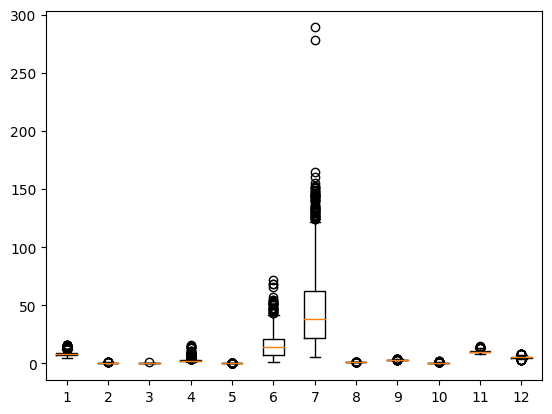

In [26]:
plt.boxplot(red_df)
plt.show()

Oh, right. Maybe having them all on the same scale isn't going to work.
Let's try our 4x3 grid of single plots again.

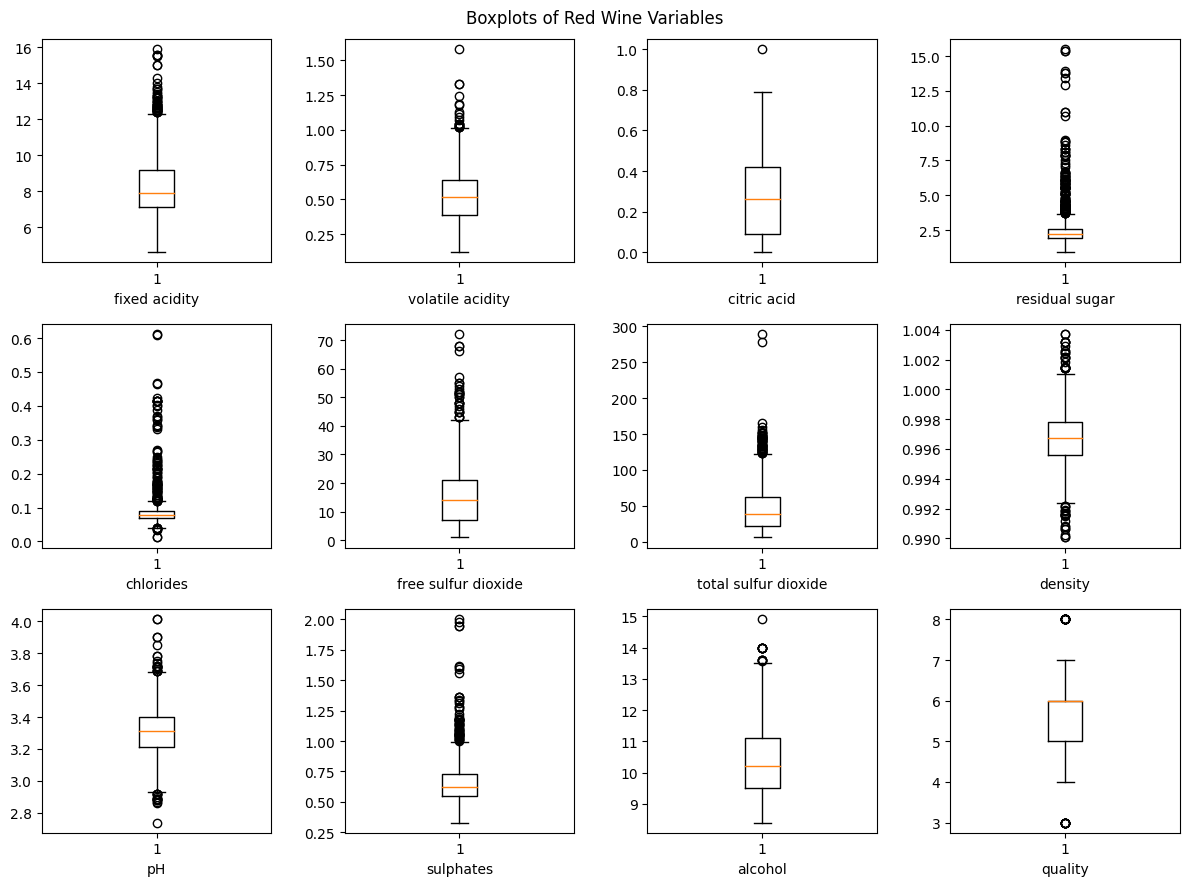

In [27]:
# prepare column names
red_col_names = red_df.columns

fig_red, axs_red = plt.subplots(3, 4, figsize=(12, 9))

# fill axes with boxplots
for i in range(12):
    if i < 4:
        axs_red[0][i].boxplot(red_df[red_col_names[i]])
        axs_red[0][i].set_xlabel(red_col_names[i])
    if 4 <= i < 8:
        axs_red[1][i-4].boxplot(red_df[red_col_names[i]])
        axs_red[1][i-4].set_xlabel(red_col_names[i])
    if i >= 8:
        axs_red[2][i-8].boxplot(red_df[red_col_names[i]])
        axs_red[2][i-8].set_xlabel(red_col_names[i])

fig_red.suptitle('Boxplots of Red Wine Variables')
fig_red.tight_layout()

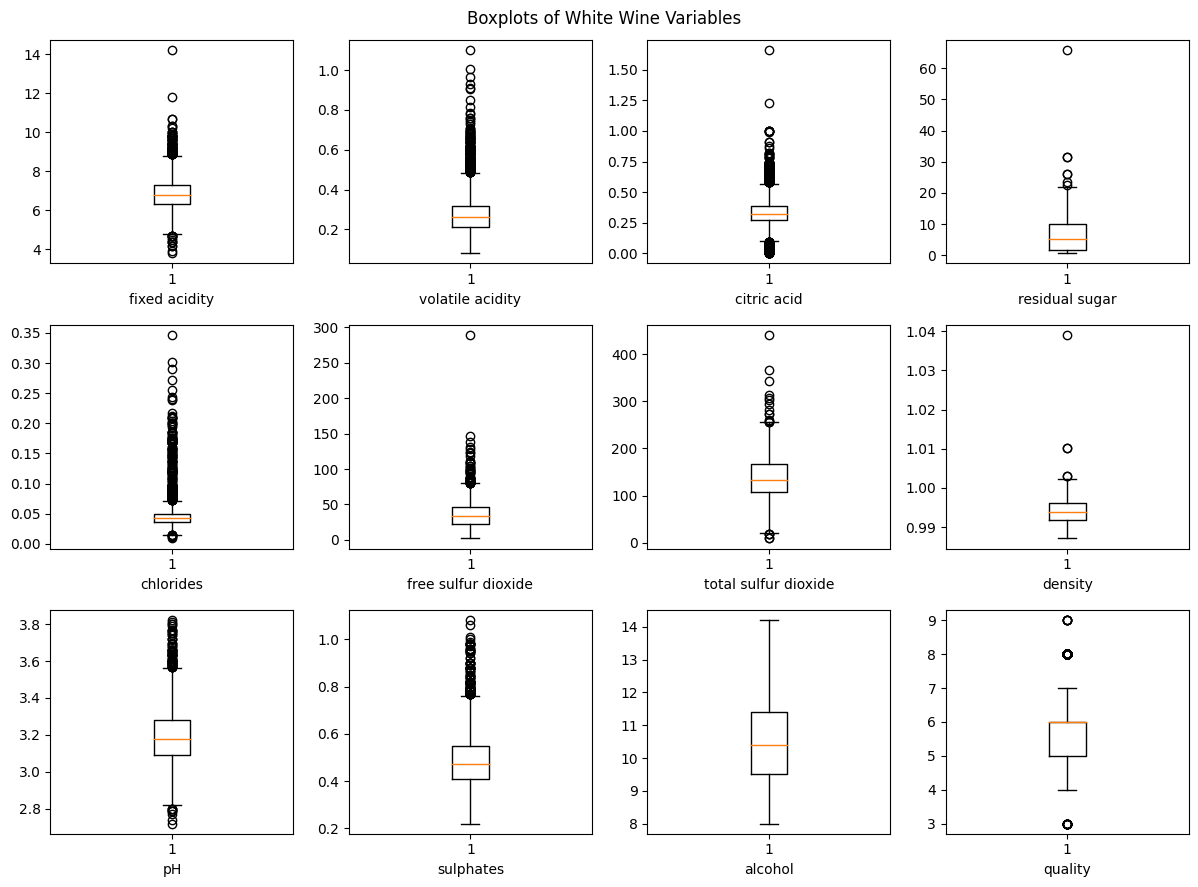

In [29]:
# prepare column names
white_col_names = white_df.columns

fig_white, axs_white = plt.subplots(3, 4, figsize=(12, 9))

# fill axes with boxplots
for i in range(12):
    if i < 4:
        axs_white[0][i].boxplot(white_df[white_col_names[i]])
        axs_white[0][i].set_xlabel(white_col_names[i])
    if 4 <= i < 8:
        axs_white[1][i-4].boxplot(white_df[white_col_names[i]])
        axs_white[1][i-4].set_xlabel(white_col_names[i])
    if i >= 8:
        axs_white[2][i-8].boxplot(white_df[white_col_names[i]])
        axs_white[2][i-8].set_xlabel(white_col_names[i])

fig_white.suptitle('Boxplots of White Wine Variables')
fig_white.tight_layout()

Oh dear. Outliers everywhere! This will heavily affect any correlations between the data, and affect outlier-sensitive machine learning algorithms (like linear regression, logistic regression, and PCA).

There are a variety of methods to handle outliers, such as:
1. Deletion: trim outliers from dataset (reduce variance but lose information)
2. Transformation: apply natural log to features with lots of outliers to reduce variation (a good option here)
3. Imputation: impute outliers with mean, median, or mode (not recommended; outliers may not be artificial)
4. Quantile flooring & capping: replace outliers with capped or floored quantile value (eliminate outliers but damages distribution)
5. Whisker stretching: increasing whisker spread, AKA raise IQR multiplier or indicate percentiles (another good option, though may encounter a negative minimum)
6. Separate treatment: treat outliers and non-outliers as two different groups, and build models for each of them (complicated and time consuming)

We probably don't want to delete all rows with outliers considering that our target variable is so imbalanced (the outlier observations might contain the anomalous target values), so we'd best start with a more measured approach.

For Linear Regression, we also have the choice to handle outliers with a Ridge Regression model, which will smooth the impact of the outliers. In the potential case of Logistic Regression, we can substitute a Ridge Classifier. However, neither presents a solution for reducing multicollinearity with PCA.

For the sake of practice, we will create separate dataframes for each dataset, apply Transformation to outlier-rich features, then run correlations to determine feature importance and PCA to determine multicollinearity.

In [33]:
# copy dataframes
red_log_df = red_df.copy()
white_log_df = white_df.copy()

# red wine features with outliers
red_log_features = red_log_df.columns
red_log_features = red_log_features.drop(labels=['citric acid', 'quality'])

# white wine features with outliers
white_log_features = white_log_df.columns
white_log_features = white_log_features.drop(labels=['alcohol', 'quality'])

# apply natural log to selected features
for feature in red_log_features:
    red_log_df[feature] = red_log_df[feature].apply(np.log)
for feature in white_log_features:
    white_log_df[feature] = white_log_df[feature].apply(np.log)

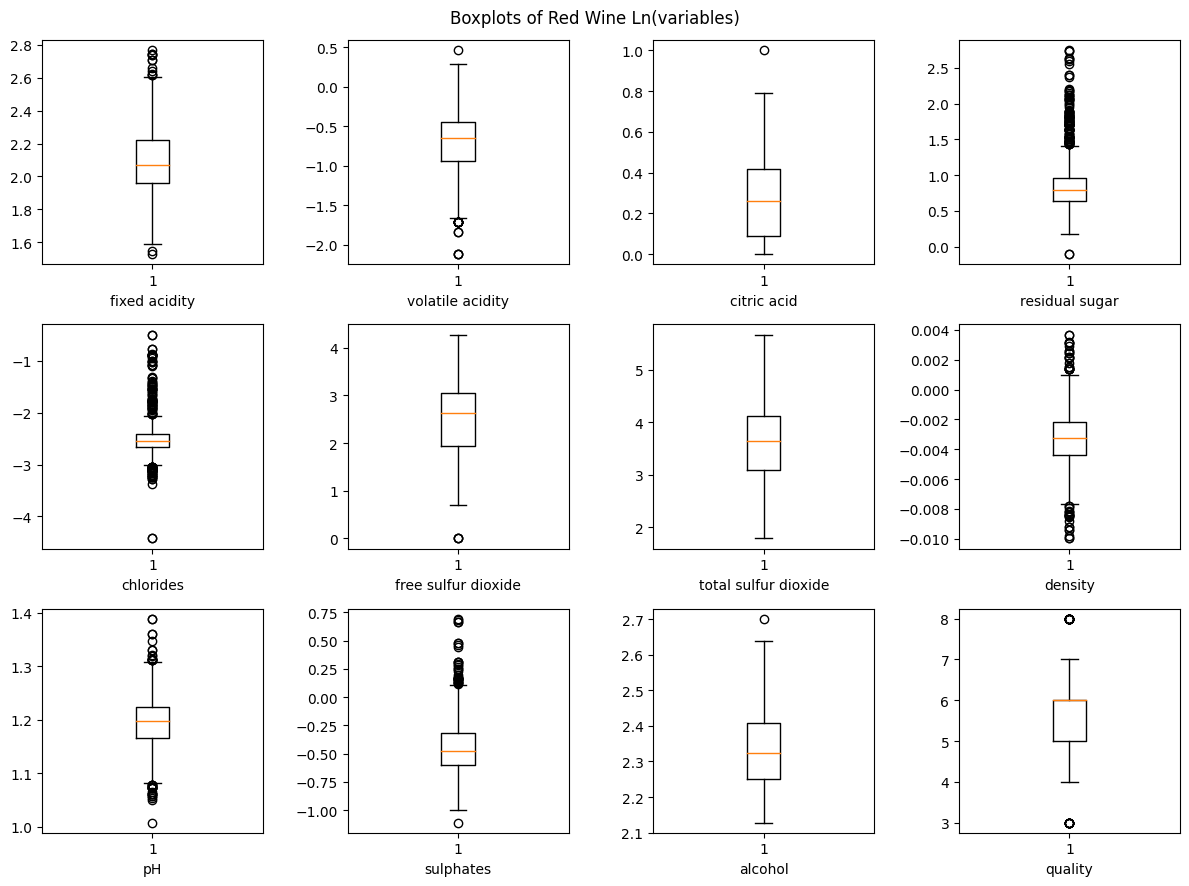

In [34]:
# prepare column names
red_col_names = red_log_df.columns

fig_red, axs_red = plt.subplots(3, 4, figsize=(12, 9))

# fill axes with boxplots
for i in range(12):
    if i < 4:
        axs_red[0][i].boxplot(red_log_df[red_col_names[i]])
        axs_red[0][i].set_xlabel(red_col_names[i])
    if 4 <= i < 8:
        axs_red[1][i-4].boxplot(red_log_df[red_col_names[i]])
        axs_red[1][i-4].set_xlabel(red_col_names[i])
    if i >= 8:
        axs_red[2][i-8].boxplot(red_log_df[red_col_names[i]])
        axs_red[2][i-8].set_xlabel(red_col_names[i])

fig_red.suptitle('Boxplots of Red Wine Ln(variables)')
fig_red.tight_layout()

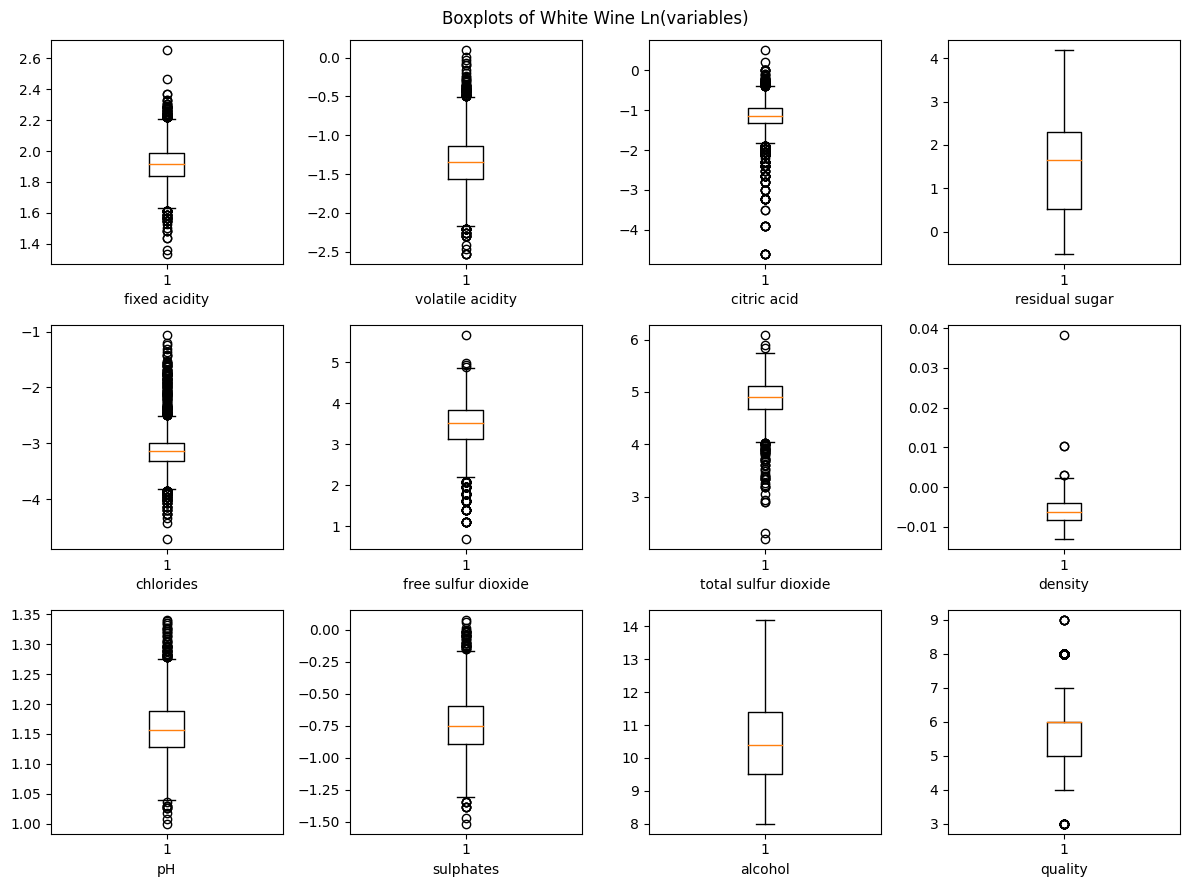

In [35]:
# prepare column names
white_col_names = white_log_df.columns

fig_white, axs_white = plt.subplots(3, 4, figsize=(12, 9))

# fill axes with boxplots
for i in range(12):
    if i < 4:
        axs_white[0][i].boxplot(white_log_df[white_col_names[i]])
        axs_white[0][i].set_xlabel(white_col_names[i])
    if 4 <= i < 8:
        axs_white[1][i-4].boxplot(white_log_df[white_col_names[i]])
        axs_white[1][i-4].set_xlabel(white_col_names[i])
    if i >= 8:
        axs_white[2][i-8].boxplot(white_log_df[white_col_names[i]])
        axs_white[2][i-8].set_xlabel(white_col_names[i])

fig_white.suptitle('Boxplots of White Wine Ln(variables)')
fig_white.tight_layout()

Well, some progress was made, though it's not as comprehensive of a solution as we were hoping for. Let's try stretching the whiskers on our original datasets and see what happens.

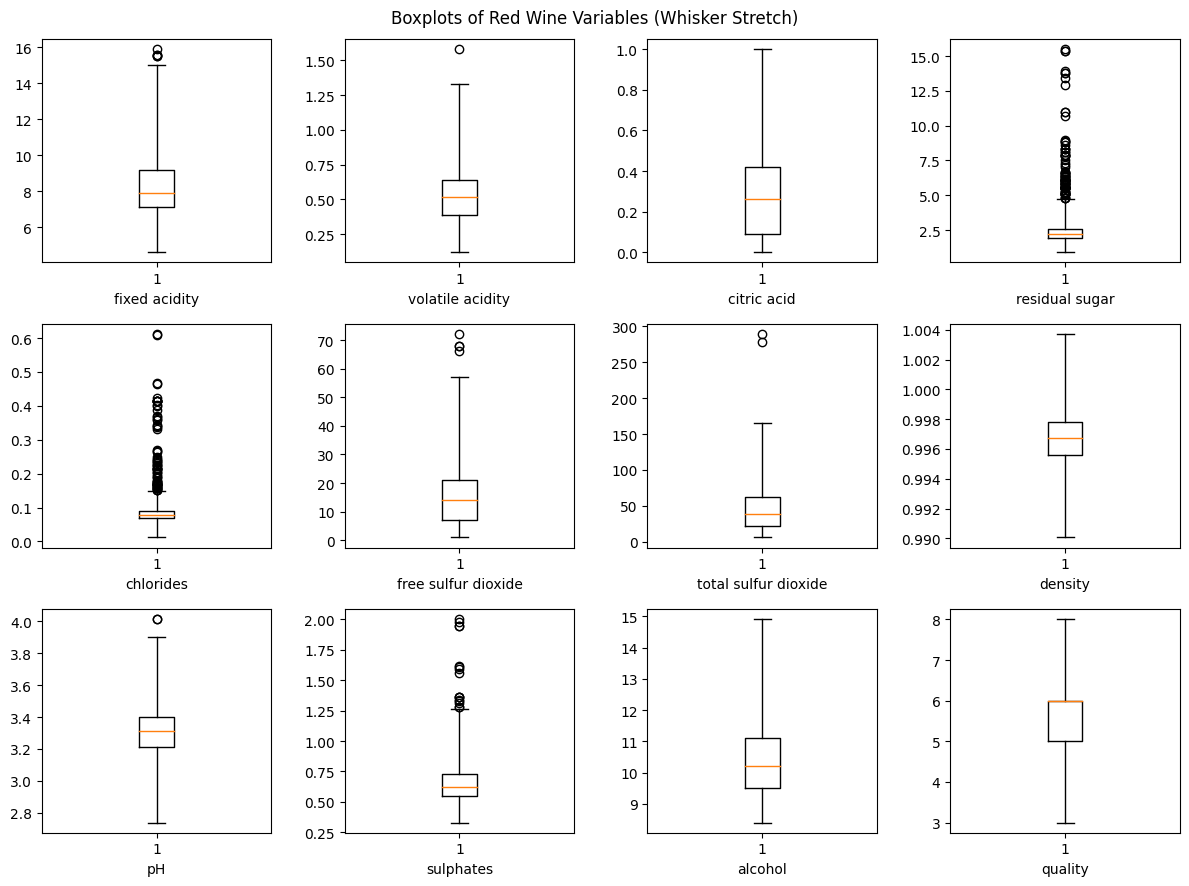

In [36]:
# prepare column names
red_col_names = red_df.columns

fig_red, axs_red = plt.subplots(3, 4, figsize=(12, 9))

# fill axes with boxplots
for i in range(12):
    if i < 4:
        axs_red[0][i].boxplot(red_df[red_col_names[i]], whis=3.0)
        axs_red[0][i].set_xlabel(red_col_names[i])
    if 4 <= i < 8:
        axs_red[1][i-4].boxplot(red_df[red_col_names[i]], whis=3.0)
        axs_red[1][i-4].set_xlabel(red_col_names[i])
    if i >= 8:
        axs_red[2][i-8].boxplot(red_df[red_col_names[i]], whis=3.0)
        axs_red[2][i-8].set_xlabel(red_col_names[i])

fig_red.suptitle('Boxplots of Red Wine Variables (Whisker Stretch)')
fig_red.tight_layout()

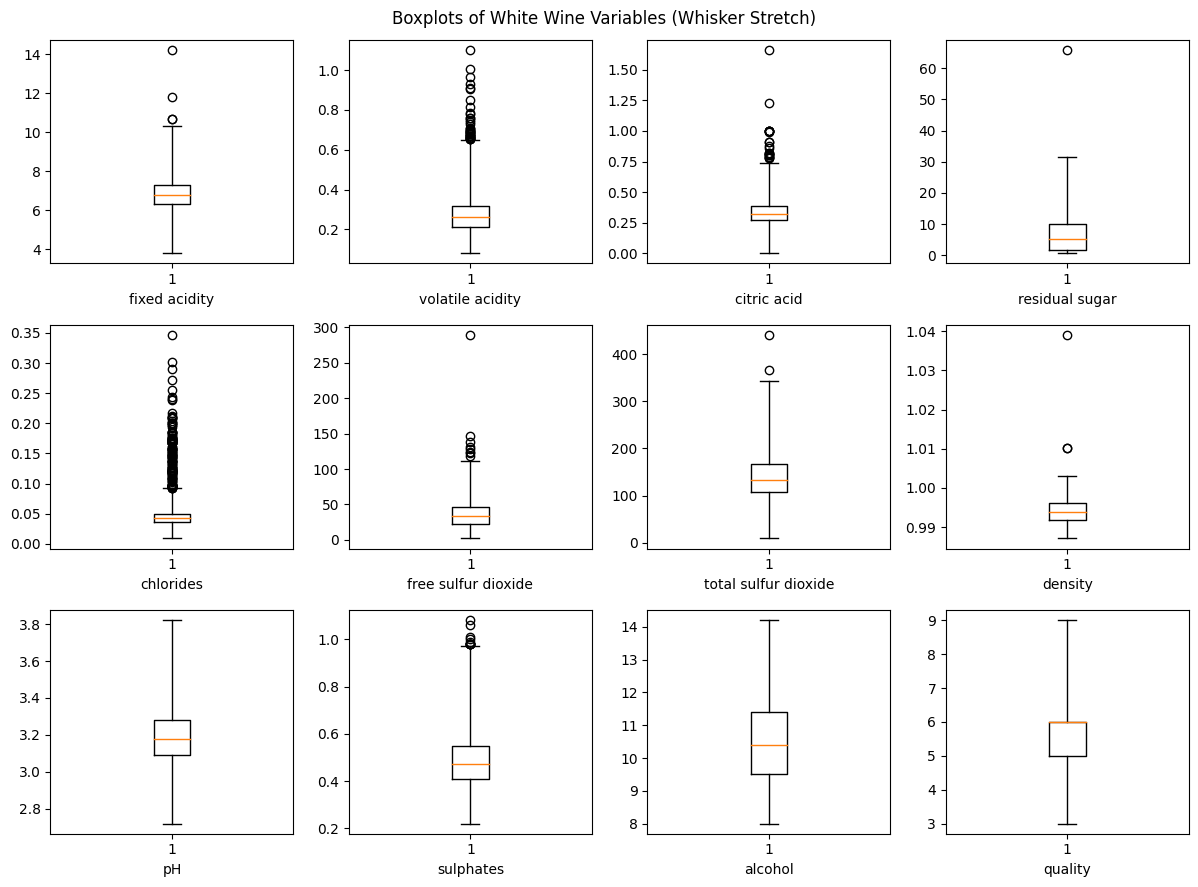

In [37]:
# prepare column names
white_col_names = white_df.columns

fig_white, axs_white = plt.subplots(3, 4, figsize=(12, 9))

# fill axes with boxplots
for i in range(12):
    if i < 4:
        axs_white[0][i].boxplot(white_df[white_col_names[i]], whis=3.0)
        axs_white[0][i].set_xlabel(white_col_names[i])
    if 4 <= i < 8:
        axs_white[1][i-4].boxplot(white_df[white_col_names[i]], whis=3.0)
        axs_white[1][i-4].set_xlabel(white_col_names[i])
    if i >= 8:
        axs_white[2][i-8].boxplot(white_df[white_col_names[i]], whis=3.0)
        axs_white[2][i-8].set_xlabel(white_col_names[i])

fig_white.suptitle('Boxplots of White Wine Variables (Whisker Stretch)')
fig_white.tight_layout()

Better, but some features are still struggling. Let's try a whisker stretch, but this time, let's determine the whisker limits by percentile (keep inner 99.5 percent) instead of an IQR multiple.

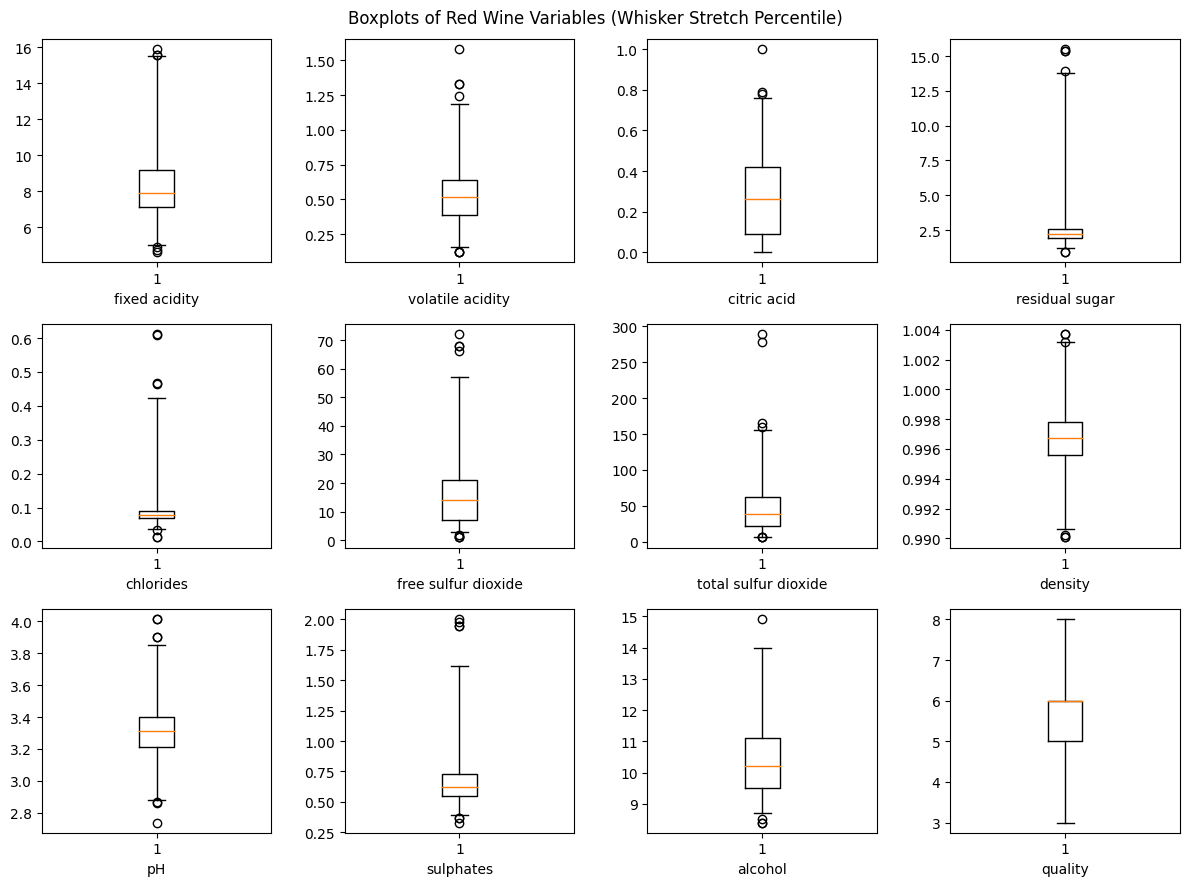

In [41]:
# prepare column names
red_col_names = red_df.columns

fig_red, axs_red = plt.subplots(3, 4, figsize=(12, 9))

# fill axes with boxplots
for i in range(12):
    if i < 4:
        axs_red[0][i].boxplot(red_df[red_col_names[i]], whis=(0.25, 99.75))
        axs_red[0][i].set_xlabel(red_col_names[i])
    if 4 <= i < 8:
        axs_red[1][i-4].boxplot(red_df[red_col_names[i]], whis=(0.25, 99.75))
        axs_red[1][i-4].set_xlabel(red_col_names[i])
    if i >= 8:
        axs_red[2][i-8].boxplot(red_df[red_col_names[i]], whis=(0.25, 99.75))
        axs_red[2][i-8].set_xlabel(red_col_names[i])

fig_red.suptitle('Boxplots of Red Wine Variables (Whisker Stretch Percentile)')
fig_red.tight_layout()

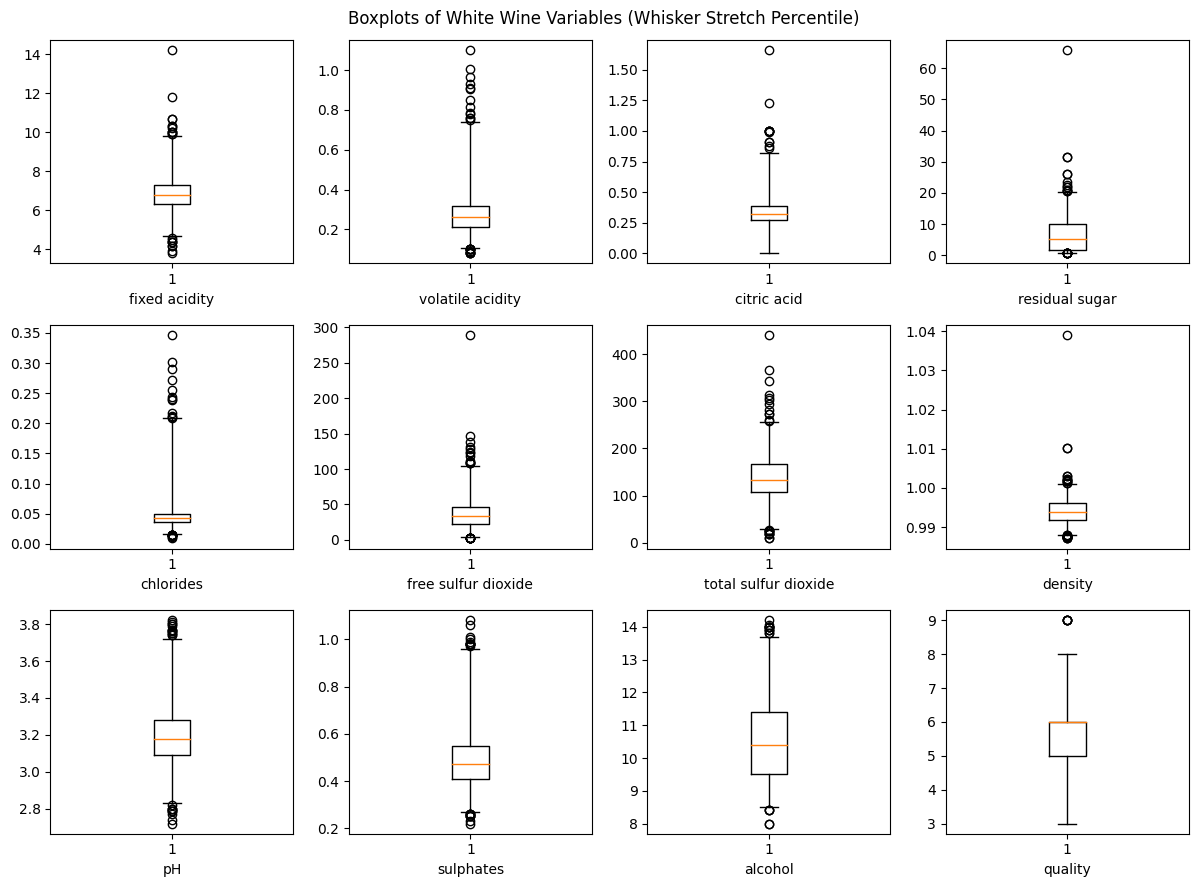

In [42]:
# prepare column names
white_col_names = white_df.columns

fig_white, axs_white = plt.subplots(3, 4, figsize=(12, 9))

# fill axes with boxplots
for i in range(12):
    if i < 4:
        axs_white[0][i].boxplot(white_df[white_col_names[i]], whis=(0.25, 99.75))
        axs_white[0][i].set_xlabel(white_col_names[i])
    if 4 <= i < 8:
        axs_white[1][i-4].boxplot(white_df[white_col_names[i]], whis=(0.25, 99.75))
        axs_white[1][i-4].set_xlabel(white_col_names[i])
    if i >= 8:
        axs_white[2][i-8].boxplot(white_df[white_col_names[i]], whis=(0.25, 99.75))
        axs_white[2][i-8].set_xlabel(white_col_names[i])

fig_white.suptitle('Boxplots of White Wine Variables (Whisker Stretch Percentile)')
fig_white.tight_layout()

A much more manageable set of outliers (at least, it looks that way)! Let's take a look at how our quality distribution is affected by removing these outliers.

In [50]:
# count and ratio of quality values (red wine)
print(red_df['quality'].value_counts().sort_index())
print(red_df['quality'].value_counts(normalize=True).sort_index())

3     10
4     53
5    681
6    638
7    199
8     18
Name: quality, dtype: int64
3    0.006254
4    0.033146
5    0.425891
6    0.398999
7    0.124453
8    0.011257
Name: quality, dtype: float64


In [49]:
# count and ratio of quality values (white wine)
print(white_df['quality'].value_counts().sort_index())
print(white_df['quality'].value_counts(normalize=True).sort_index())

3      20
4     163
5    1457
6    2198
7     880
8     175
9       5
Name: quality, dtype: int64
3    0.004083
4    0.033279
5    0.297468
6    0.448755
7    0.179665
8    0.035729
9    0.001021
Name: quality, dtype: float64


In [51]:
# whisker bound functions
def lower_whisker(series):
    return np.percentile(a=series, q=0.25)

def upper_whisker(series):
    return np.percentile(a=series, q=99.75)

In [91]:
# whisker trim dfs
red_whis_trim_df = red_df.copy()
white_whis_trim_df = white_df.copy()

# all features (except target)
red_whis_trim_cols = red_whis_trim_df.columns.drop(labels=['quality'])
white_whis_trim_cols = white_whis_trim_df.columns.drop(labels=['quality'])

# indices to drop
red_index_drop_set = set()
white_index_drop_set = set()

# add trimmed row indices to drop sets
for feature in red_whis_trim_cols:
    red_inds = red_whis_trim_df[feature].loc[
        (red_whis_trim_df[feature] <= lower_whisker(red_whis_trim_df[feature])) |
        (red_whis_trim_df[feature] >= upper_whisker(red_whis_trim_df[feature]))
        ]
    for ind in red_inds.index:
        red_index_drop_set.add(ind)
for feature in white_whis_trim_cols:
    white_inds = white_whis_trim_df[feature].loc[
        (white_whis_trim_df[feature] <= lower_whisker(white_whis_trim_df[feature])) |
        (white_whis_trim_df[feature] >= upper_whisker(white_whis_trim_df[feature]))
        ]
    for ind in white_inds.index:
        white_index_drop_set.add(ind)

# drop rows
red_whis_trim_df = red_whis_trim_df.drop(index=red_index_drop_set)
white_whis_trim_df = white_whis_trim_df.drop(index=white_index_drop_set)

In [92]:
# count and ratio of quality values (red wine, after whisker trim)
print(red_whis_trim_df['quality'].value_counts().sort_index())
print(red_whis_trim_df['quality'].value_counts(normalize=True).sort_index())

3      6
4     38
5    599
6    555
7    179
8     15
Name: quality, dtype: int64
3    0.004310
4    0.027299
5    0.430316
6    0.398707
7    0.128592
8    0.010776
Name: quality, dtype: float64


In [93]:
# count and ratio of quality values (white wine, after whisker trim)
print(white_whis_trim_df['quality'].value_counts().sort_index())
print(white_whis_trim_df['quality'].value_counts(normalize=True).sort_index())

3       8
4     133
5    1370
6    2082
7     832
8     164
9       5
Name: quality, dtype: int64
3    0.001741
4    0.028951
5    0.298215
6    0.453200
7    0.181106
8    0.035699
9    0.001088
Name: quality, dtype: float64


Our efforts were worthwhile! We've removed the most egregious outliers without sacrificing too many anomalous values.

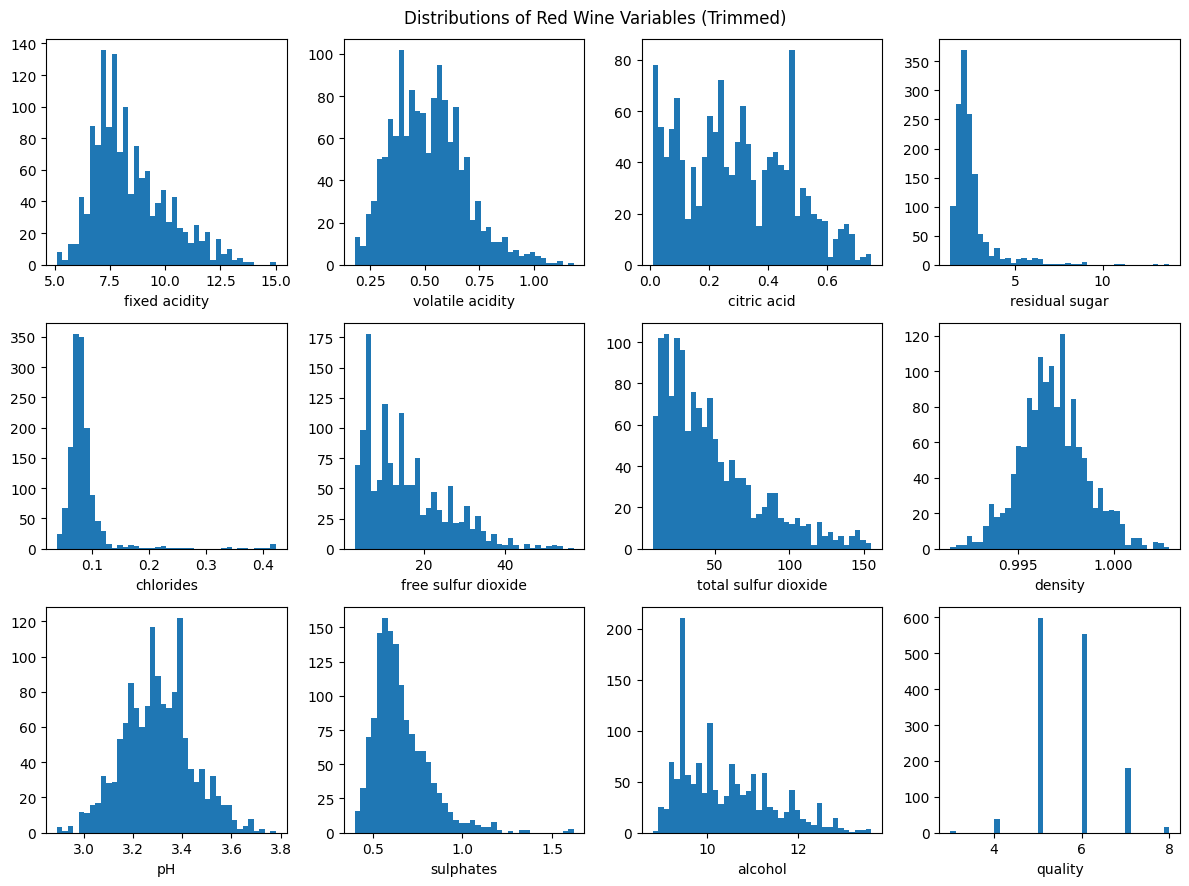

In [94]:
# prepare column names
red_col_names = red_whis_trim_df.columns

fig_red, axs_red = plt.subplots(3, 4, figsize=(12, 9))

# fill axes with distributions
for i in range(12):
    if i < 4:
        axs_red[0][i].hist(red_whis_trim_df[red_col_names[i]], bins=40)
        axs_red[0][i].set_xlabel(red_col_names[i])
    if 4 <= i < 8:
        axs_red[1][i-4].hist(red_whis_trim_df[red_col_names[i]], bins=40)
        axs_red[1][i-4].set_xlabel(red_col_names[i])
    if i >= 8:
        axs_red[2][i-8].hist(red_whis_trim_df[red_col_names[i]], bins=40)
        axs_red[2][i-8].set_xlabel(red_col_names[i])

fig_red.suptitle('Distributions of Red Wine Variables (Trimmed)')
fig_red.tight_layout()

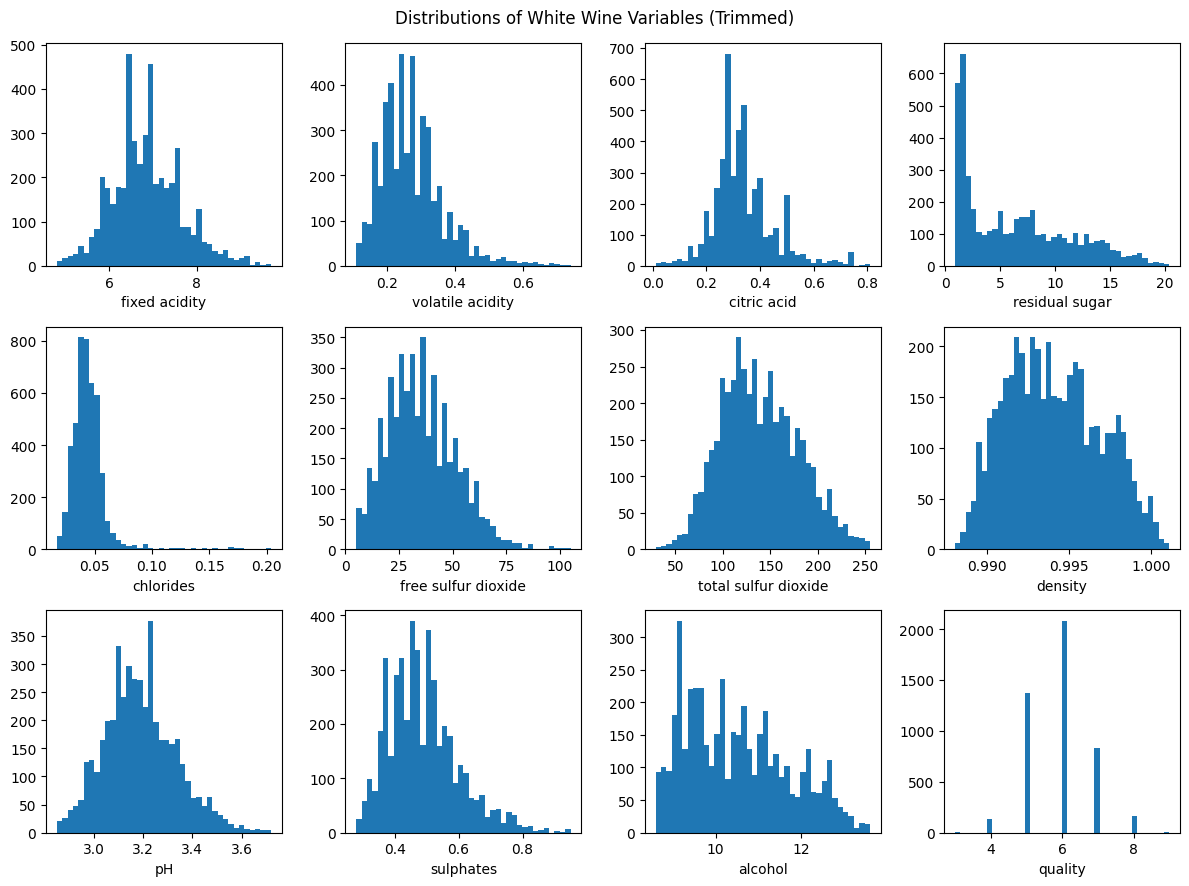

In [95]:
# prepare column names
white_col_names = white_whis_trim_df.columns

fig_white, axs_white = plt.subplots(3, 4, figsize=(12, 9))

# fill axes with distributions
for i in range(12):
    if i < 4:
        axs_white[0][i].hist(white_whis_trim_df[white_col_names[i]], bins=40)
        axs_white[0][i].set_xlabel(white_col_names[i])
    if 4 <= i < 8:
        axs_white[1][i-4].hist(white_whis_trim_df[white_col_names[i]], bins=40)
        axs_white[1][i-4].set_xlabel(white_col_names[i])
    if i >= 8:
        axs_white[2][i-8].hist(white_whis_trim_df[white_col_names[i]], bins=40)
        axs_white[2][i-8].set_xlabel(white_col_names[i])

fig_white.suptitle('Distributions of White Wine Variables (Trimmed)')
fig_white.tight_layout()

The plots are looking much better. We still have some pretty skewed graphs that we could clean up.

Red:
- residual sugar
- chlorides
- sulphates

White:
- volatile acidity
- chlorides

It would be nice to clean these up without damaging our anomalous target values. We do need to be careful about adding outlier cuts on top of each other (the data wrangling gets messy) but we'll give it a try and see if our correlations pay off. Let's create new dataframes for the double-trimmed datasets.

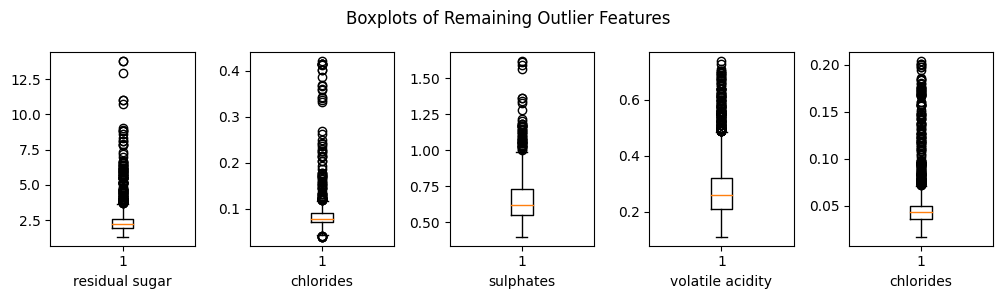

In [99]:
# prepare plots
fig_rw, axs_rw = plt.subplots(1, 5, figsize=(10, 3))

# features with outliers
r_outs = ['residual sugar', 'chlorides', 'sulphates']
w_outs = ['volatile acidity', 'chlorides']

# fill axes with boxplots
for i in range(3):
    axs_rw[i].boxplot(red_whis_trim_df[r_outs[i]])
    axs_rw[i].set_xlabel(r_outs[i])
for i in range(3, 5):
    axs_rw[i].boxplot(white_whis_trim_df[w_outs[i-3]])
    axs_rw[i].set_xlabel(w_outs[i-3])

fig_rw.suptitle('Boxplots of Remaining Outlier Features')
fig_rw.tight_layout()

In [100]:
# standard whisker min & max
def whis_minmax(series):
    q1 = np.percentile(series, q=25.0)
    q3 = np.percentile(series, q=75.0)
    iqr = q3 - q1
    whis_min = q1 - (iqr * 1.5)
    whis_max = q3 + (iqr * 1.5)
    return whis_min, whis_max

In [101]:
# whisker double trim dfs
red_whis_dbl_trim_df = red_whis_trim_df.copy()
white_whis_dbl_trim_df = white_whis_trim_df.copy()

# indices to drop
red_index_drop_set = set()
white_index_drop_set = set()

# add trimmed row indices to drop sets
for feature in r_outs:
    red_lower, red_upper = whis_minmax(red_whis_dbl_trim_df[feature])
    red_inds = red_whis_dbl_trim_df[feature].loc[
        (red_whis_dbl_trim_df[feature] <= red_lower) |
        (red_whis_dbl_trim_df[feature] >= red_upper)
        ]
    for ind in red_inds.index:
        red_index_drop_set.add(ind)
for feature in w_outs:
    white_lower, white_upper = whis_minmax(white_whis_dbl_trim_df[feature])
    white_inds = white_whis_dbl_trim_df[feature].loc[
        (white_whis_dbl_trim_df[feature] <= white_lower) |
        (white_whis_dbl_trim_df[feature] >= white_upper)
        ]
    for ind in white_inds.index:
        white_index_drop_set.add(ind)

# drop rows
red_whis_dbl_trim_df = red_whis_dbl_trim_df.drop(index=red_index_drop_set)
white_whis_dbl_trim_df = white_whis_dbl_trim_df.drop(index=white_index_drop_set)

In [102]:
# count and ratio of quality values (red wine, after double whisker trim)
print(red_whis_dbl_trim_df['quality'].value_counts().sort_index())
print(red_whis_dbl_trim_df['quality'].value_counts(normalize=True).sort_index())

3      4
4     26
5    513
6    472
7    138
8     12
Name: quality, dtype: int64
3    0.003433
4    0.022318
5    0.440343
6    0.405150
7    0.118455
8    0.010300
Name: quality, dtype: float64


In [103]:
# count and ratio of quality values (white wine, after double whisker trim)
print(white_whis_dbl_trim_df['quality'].value_counts().sort_index())
print(white_whis_dbl_trim_df['quality'].value_counts(normalize=True).sort_index())

3       7
4     103
5    1229
6    1974
7     819
8     154
9       5
Name: quality, dtype: int64
3    0.001631
4    0.024004
5    0.286413
6    0.460033
7    0.190865
8    0.035889
9    0.001165
Name: quality, dtype: float64


We lost most of our 3-rated observations in the outlier trimming, but at least we still have values for them! Let's take one final look at our distributions.

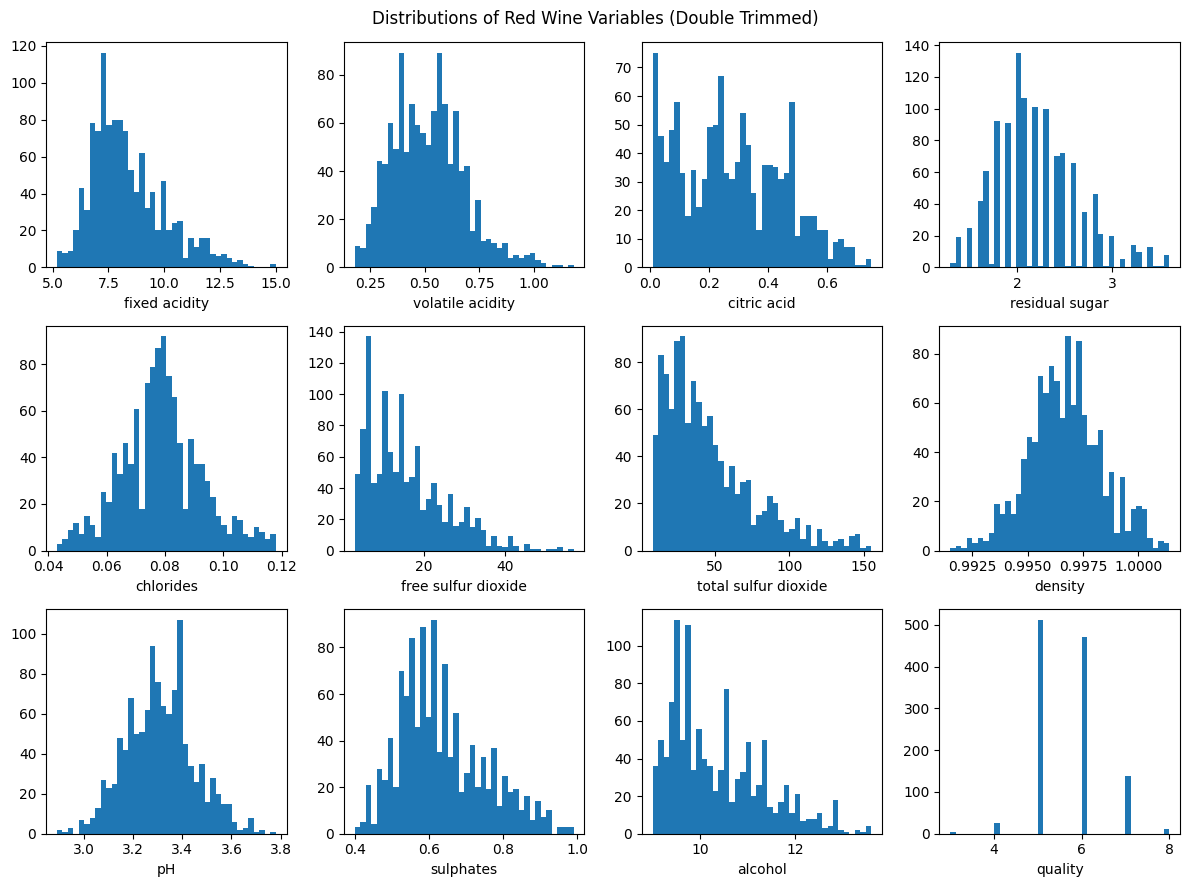

In [104]:
# prepare column names
red_col_names = red_whis_dbl_trim_df.columns

fig_red, axs_red = plt.subplots(3, 4, figsize=(12, 9))

# fill axes with distributions
for i in range(12):
    if i < 4:
        axs_red[0][i].hist(red_whis_dbl_trim_df[red_col_names[i]], bins=40)
        axs_red[0][i].set_xlabel(red_col_names[i])
    if 4 <= i < 8:
        axs_red[1][i-4].hist(red_whis_dbl_trim_df[red_col_names[i]], bins=40)
        axs_red[1][i-4].set_xlabel(red_col_names[i])
    if i >= 8:
        axs_red[2][i-8].hist(red_whis_dbl_trim_df[red_col_names[i]], bins=40)
        axs_red[2][i-8].set_xlabel(red_col_names[i])

fig_red.suptitle('Distributions of Red Wine Variables (Double Trimmed)')
fig_red.tight_layout()

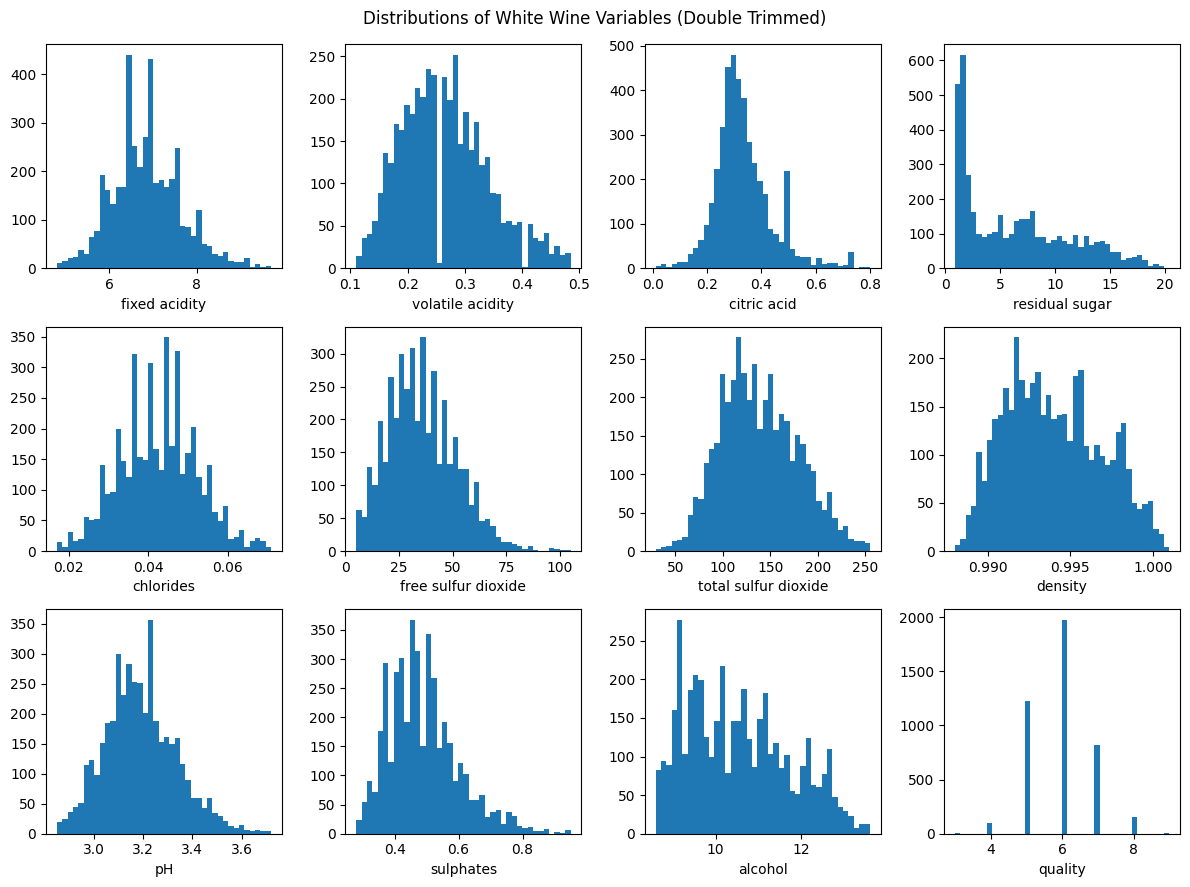

In [105]:
# prepare column names
white_col_names = white_whis_dbl_trim_df.columns

fig_white, axs_white = plt.subplots(3, 4, figsize=(12, 9))

# fill axes with distributions
for i in range(12):
    if i < 4:
        axs_white[0][i].hist(white_whis_dbl_trim_df[white_col_names[i]], bins=40)
        axs_white[0][i].set_xlabel(white_col_names[i])
    if 4 <= i < 8:
        axs_white[1][i-4].hist(white_whis_dbl_trim_df[white_col_names[i]], bins=40)
        axs_white[1][i-4].set_xlabel(white_col_names[i])
    if i >= 8:
        axs_white[2][i-8].hist(white_whis_dbl_trim_df[white_col_names[i]], bins=40)
        axs_white[2][i-8].set_xlabel(white_col_names[i])

fig_white.suptitle('Distributions of White Wine Variables (Double Trimmed)')
fig_white.tight_layout()

Everything looks so much more normal! Still not perfect, but loads better than it was when we started.

### Correlations & PCA

Now that our distributions are less outlier-rich, let's look at how our variables correlate to the target variable, and to each other. Then we'll perform PCA on the features as a second opinion on feature importance and multicollinearity.

In [107]:
red_whis_dbl_trim_df.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.243420,0.686913,0.265681,0.183660,-0.136354,-0.102577,0.667932,-0.692484,0.184345,-0.062577,0.115394
volatile acidity,-0.243420,1.000000,-0.560694,0.032466,0.105335,-0.028341,0.138692,0.025820,0.186190,-0.341553,-0.195561,-0.370881
citric acid,0.686913,-0.560694,1.000000,0.170910,0.111292,-0.060423,-0.027468,0.377336,-0.495989,0.267091,0.112217,0.212014
residual sugar,0.265681,0.032466,0.170910,1.000000,0.210809,0.058978,0.145567,0.416185,-0.071657,0.064648,0.099140,0.020656
chlorides,0.183660,0.105335,0.111292,0.210809,1.000000,0.010343,0.182061,0.395013,-0.186277,-0.076569,-0.297266,-0.198242
free sulfur dioxide,-0.136354,-0.028341,-0.060423,0.058978,0.010343,1.000000,0.642956,-0.039999,0.124576,0.075347,-0.027065,-0.020544
total sulfur dioxide,-0.102577,0.138692,-0.027468,0.145567,0.182061,0.642956,1.000000,0.106131,-0.003701,-0.122132,-0.263062,-0.247000
density,0.667932,0.025820,0.377336,0.416185,0.395013,-0.039999,0.106131,1.000000,-0.288063,0.077027,-0.512698,-0.212252
pH,-0.692484,0.186190,-0.495989,-0.071657,-0.186277,0.124576,-0.003701,-0.288063,1.000000,0.004657,0.156657,-0.057759
sulphates,0.184345,-0.341553,0.267091,0.064648,-0.076569,0.075347,-0.122132,0.077027,0.004657,1.000000,0.292806,0.426918


In [108]:
white_whis_dbl_trim_df.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.042287,0.284730,0.067888,0.090036,-0.032288,0.090334,0.252783,-0.391527,-0.010767,-0.112600,-0.090435
volatile acidity,-0.042287,1.000000,-0.112526,0.058968,-0.035412,-0.060758,0.110372,-0.015873,-0.057718,-0.053824,0.090947,-0.136357
citric acid,0.284730,-0.112526,1.000000,0.090218,0.037348,0.099435,0.118726,0.150026,-0.130420,0.085071,-0.076938,-0.034763
residual sugar,0.067888,0.058968,0.090218,1.000000,0.271105,0.340678,0.409478,0.842853,-0.201216,-0.040955,-0.501077,-0.123219
chlorides,0.090036,-0.035412,0.037348,0.271105,1.000000,0.155143,0.359336,0.489867,-0.019992,0.063025,-0.543528,-0.284552
free sulfur dioxide,-0.032288,-0.060758,0.099435,0.340678,0.155143,1.000000,0.609590,0.333268,-0.018539,0.060362,-0.267145,0.006697
total sulfur dioxide,0.090334,0.110372,0.118726,0.409478,0.359336,0.609590,1.000000,0.546346,-0.008616,0.116244,-0.473667,-0.185970
density,0.252783,-0.015873,0.150026,0.842853,0.489867,0.333268,0.546346,1.000000,-0.084756,0.075279,-0.819867,-0.317489
pH,-0.391527,-0.057718,-0.130420,-0.201216,-0.019992,-0.018539,-0.008616,-0.084756,1.000000,0.159990,0.107905,0.093607
sulphates,-0.010767,-0.053824,0.085071,-0.040955,0.063025,0.060362,0.116244,0.075279,0.159990,1.000000,-0.042014,0.039568


It's tough to see what's going on through all the numbers. Let's make a heatmap!

<AxesSubplot: >

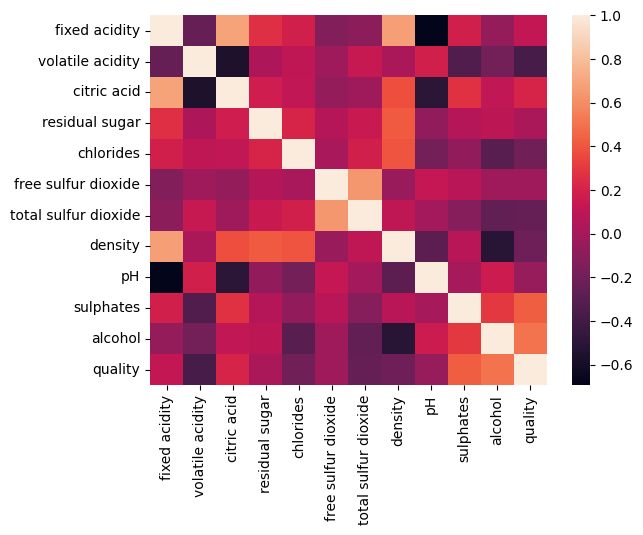

In [109]:
sns.heatmap(red_whis_dbl_trim_df.corr())

<AxesSubplot: >

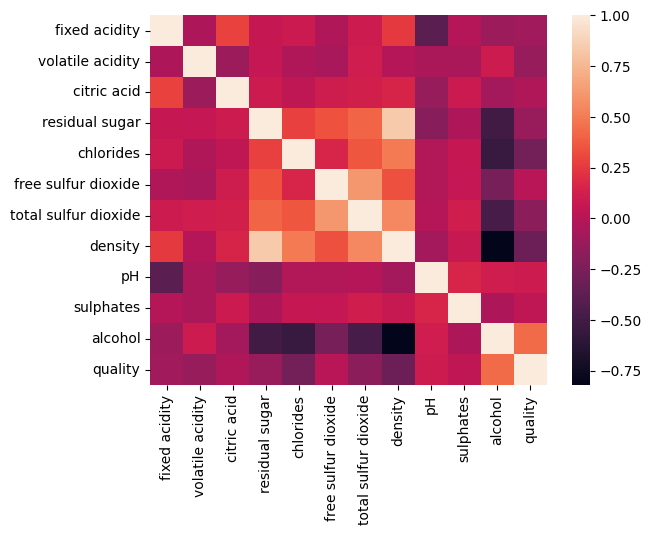

In [110]:
sns.heatmap(white_whis_dbl_trim_df.corr())

The colors are quite messy, we don't have any numbers, and the top half of the graph is redundant!  

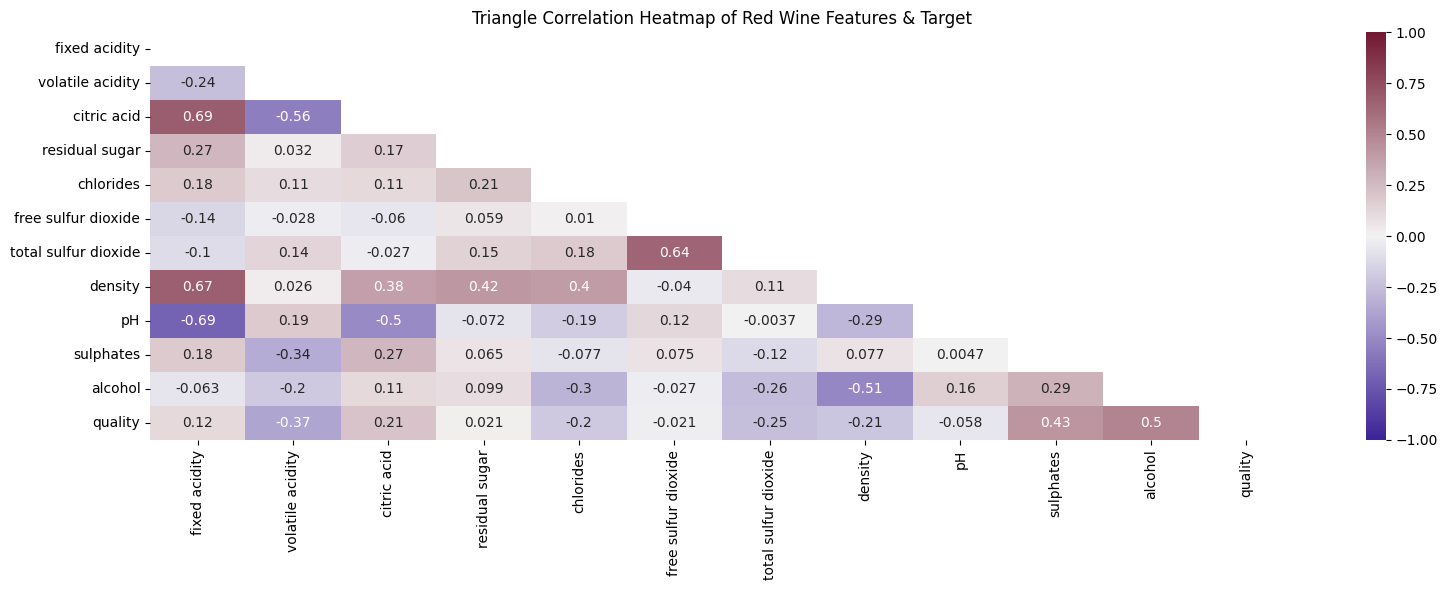

In [115]:
fig = plt.figure(figsize=(16, 6))

mask = np.triu(np.ones_like(red_whis_dbl_trim_df.corr()))

heatmap = sns.heatmap(red_whis_dbl_trim_df.corr(),
                    mask=mask,
                    vmin=-1, vmax=1,
                    annot=True,
                    cmap=sns.diverging_palette(270, 0, s=80, l=25, as_cmap=True))

heatmap.set_title('Triangle Correlation Heatmap of Red Wine Features & Target')

fig.tight_layout()


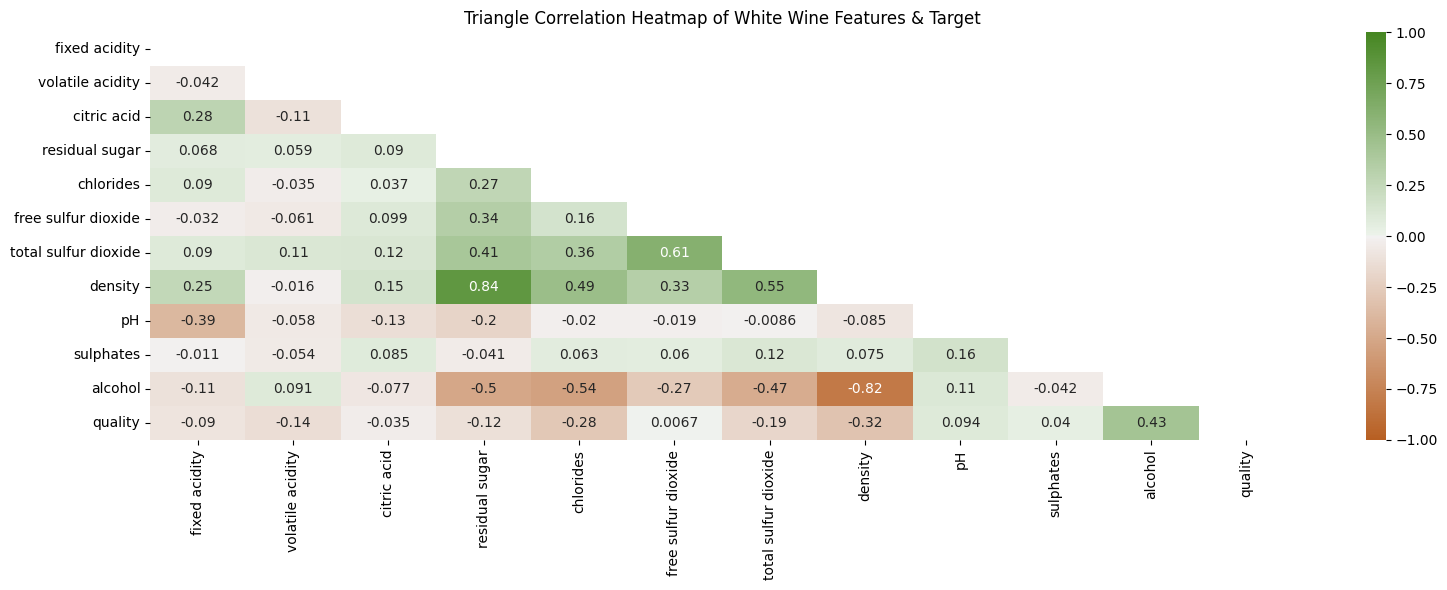

In [117]:
fig = plt.figure(figsize=(16, 6))

mask = np.triu(np.ones_like(white_whis_dbl_trim_df.corr()))

heatmap = sns.heatmap(white_whis_dbl_trim_df.corr(),
                    mask=mask,
                    vmin=-1, vmax=1,
                    annot=True,
                    cmap=sns.diverging_palette(30, 120, s=90, l=50, as_cmap=True))

heatmap.set_title('Triangle Correlation Heatmap of White Wine Features & Target')

fig.tight_layout()

Much better. Now we can get to know our correlation values!

For red wine:
- total sulfur oxide vs free sulfur oxide: strong positive
- fixed acidity vs density: strong postive
- fixed acidity vs citric acid: strong postive
- volatile acidity vs citric acid: moderate negative
- pH vs citric acid: moderate negative
- alcohol vs density: moderate negative
- fixed acidity vs pH: strong negative
- strongest with target(quality): alcohol(mp), sulphates(mp), volatile acidity(mn)

For white wine:
- density vs residual sugar: strong positive
- total sulfur oxide vs free sulfur oxide: strong positive
- total sulfur oxide vs density: moderate positive
- density vs chlorides: moderate positive
- total sulfur oxide vs residual sugar: moderate positive
- pH vs fixed acidity: moderate negative
- alcohol vs total sulfur dioxide: moderate negative
- alcohol vs residual sugar: moderate negative
- alcohol vs chlorides: moderate negative
- alcohol vs density: strong negative
- strongest with target(quality): alcohol(mp), density(wn), chlorides(wn)

That's a lot of info. Let's unpack this.

Or maybe not. (Sudden shift to first person!) I've put some thought into how I want to approach this, and honestly, I have no idea what I'm doing. It's getting so messy and complicated, and that's code for "there's an easier way". So I'm going to take a step back and try to remember why I'm doing all of this to begin with.

As far as multicollinearity goes, I could try variance inflation factor (VIF) which I've never tried before, but it seems like it could be more useful than just looking at a triangle of correlations.

What I'm more interested in is how to preserve the anomalous target values for use in our machine learning model. I have to do some research on anomaly detection machines, and working with imbalanced datasets.

### If at First You Don't Succeed

I've taken some time away from this problem, and I believe it's time to reframe the objectives for this notebook.

I really wanted to try out PCA on this problem, which is why I was so focused on smoothing out the distributions and preparing the data for correlation analysis. But given that I'm doing all this work to fit (more than one?) machine learning algorithms, I probably shouldn't be going through hassle if it's unnecessary.

For the rest of the notebook, I'm hoping to stick to a more iterative approach: Fit the data as is, see what comes out of it, and make small adjustments as necessary to increase the accuracy of my models. While this approach is less "explorative", I'm not sure the "explorative" approach is going to provide more benefit, so let's keep to the scope and objectives of the project, which I'm going to redefine.

## Redefining Objective

The overall goal: Create an accurate machine learning algorithm for predicing wine quality.

### Notes on the New Approach

I can choose either regression or classification for this. I'm split on which I should choose. The fact that the target values are discrete gives me reason to choose classification, but because the values are ordinal, I can also work with regression (and, should the regression outputs be continuous, find some way to convert them to the discrete target values). I expect to try them both and see which one works better.

Since I'm working with an imbalanced dataset, I won't be using simple accuracy as a performance metric. I will most likely choose some method that operates like a confusion matrix. Perhaps F1-score, or ROC/AUC.

I've looked into some methods for how to better balance the data. Given that I'm not working with a whole lot of data (several thousand points for each set), I expect that I'll be generating synthetic samples for the anomaly classes. I'll look into that later.

## Second Iteration

Let's start over with a fresh pull of the data. For now, even though the dataset is imbalanced, there are a ton of outliers, and I'm not sure how the features contribute to (or detract from) my model's performance, at least the data we have is in a clean format. Let's fit some models and see what happens.

### Getting the Data

We already have our data in white_df and red_df, but just to make sure we haven't altered it in our previous steps, let's reload it (and so we don't have to run any code from the first iteration).

In [2]:
# loading datasets
red_df = pd.read_csv('winequality-red.csv', delimiter=';')
white_df = pd.read_csv('winequality-white.csv', delimiter=';')
print(red_df.shape)
print(white_df.shape)

(1599, 12)
(4898, 12)


In [3]:
red_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
white_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### EDA 1

We've already done a lot of EDA, but let's take a look at our distributions again, just to have it nearby.

Also, there was a lot of copy-paste in the first iteration. Let's make our distributions a little more reusable with a function.

In [7]:
# graphs variable distributions
def graph_distributions(df, wine_type=""):

    # prepare column names
    df_cols = df.columns

    fig, axs = plt.subplots(3, 4, figsize=(8, 6))

    # fill axes with distributions
    for i in range(12):
        if i < 4:
            axs[0][i].hist(df[df_cols[i]], bins=40)
            axs[0][i].set_xlabel(df_cols[i])
        if 4 <= i < 8:
            axs[1][i-4].hist(df[df_cols[i]], bins=40)
            axs[1][i-4].set_xlabel(df_cols[i])
        if i >= 8:
            axs[2][i-8].hist(df[df_cols[i]], bins=40)
            axs[2][i-8].set_xlabel(df_cols[i])

    fig.suptitle(f'Distributions of {wine_type} Wine Features')

    return fig.tight_layout()

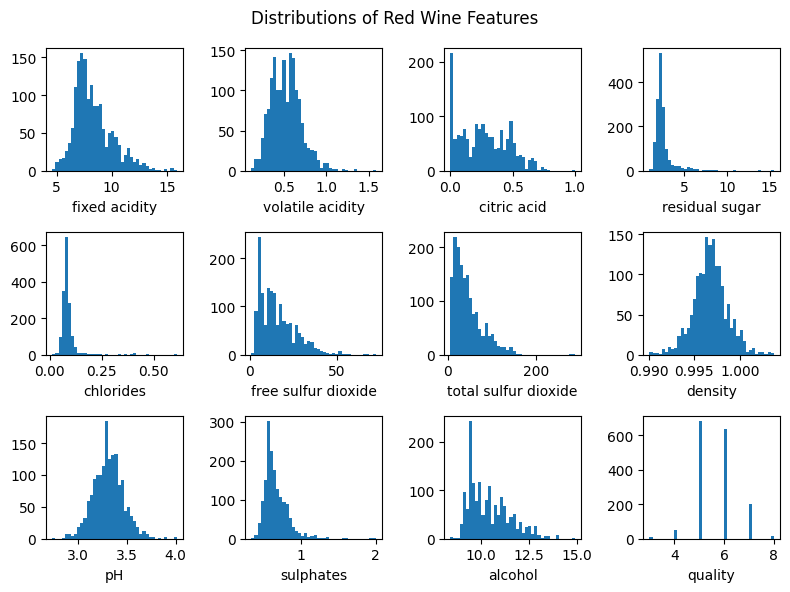

In [8]:
graph_distributions(red_df, "Red")

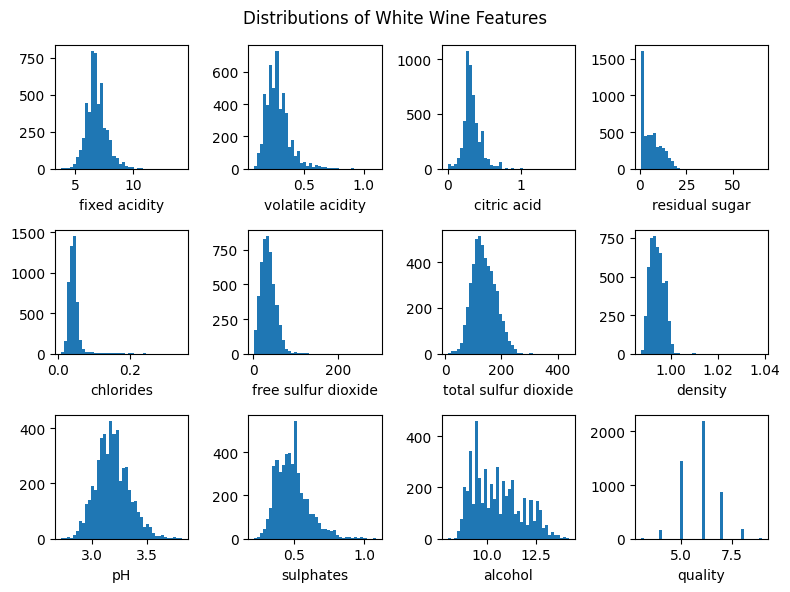

In [9]:
graph_distributions(white_df, "White")

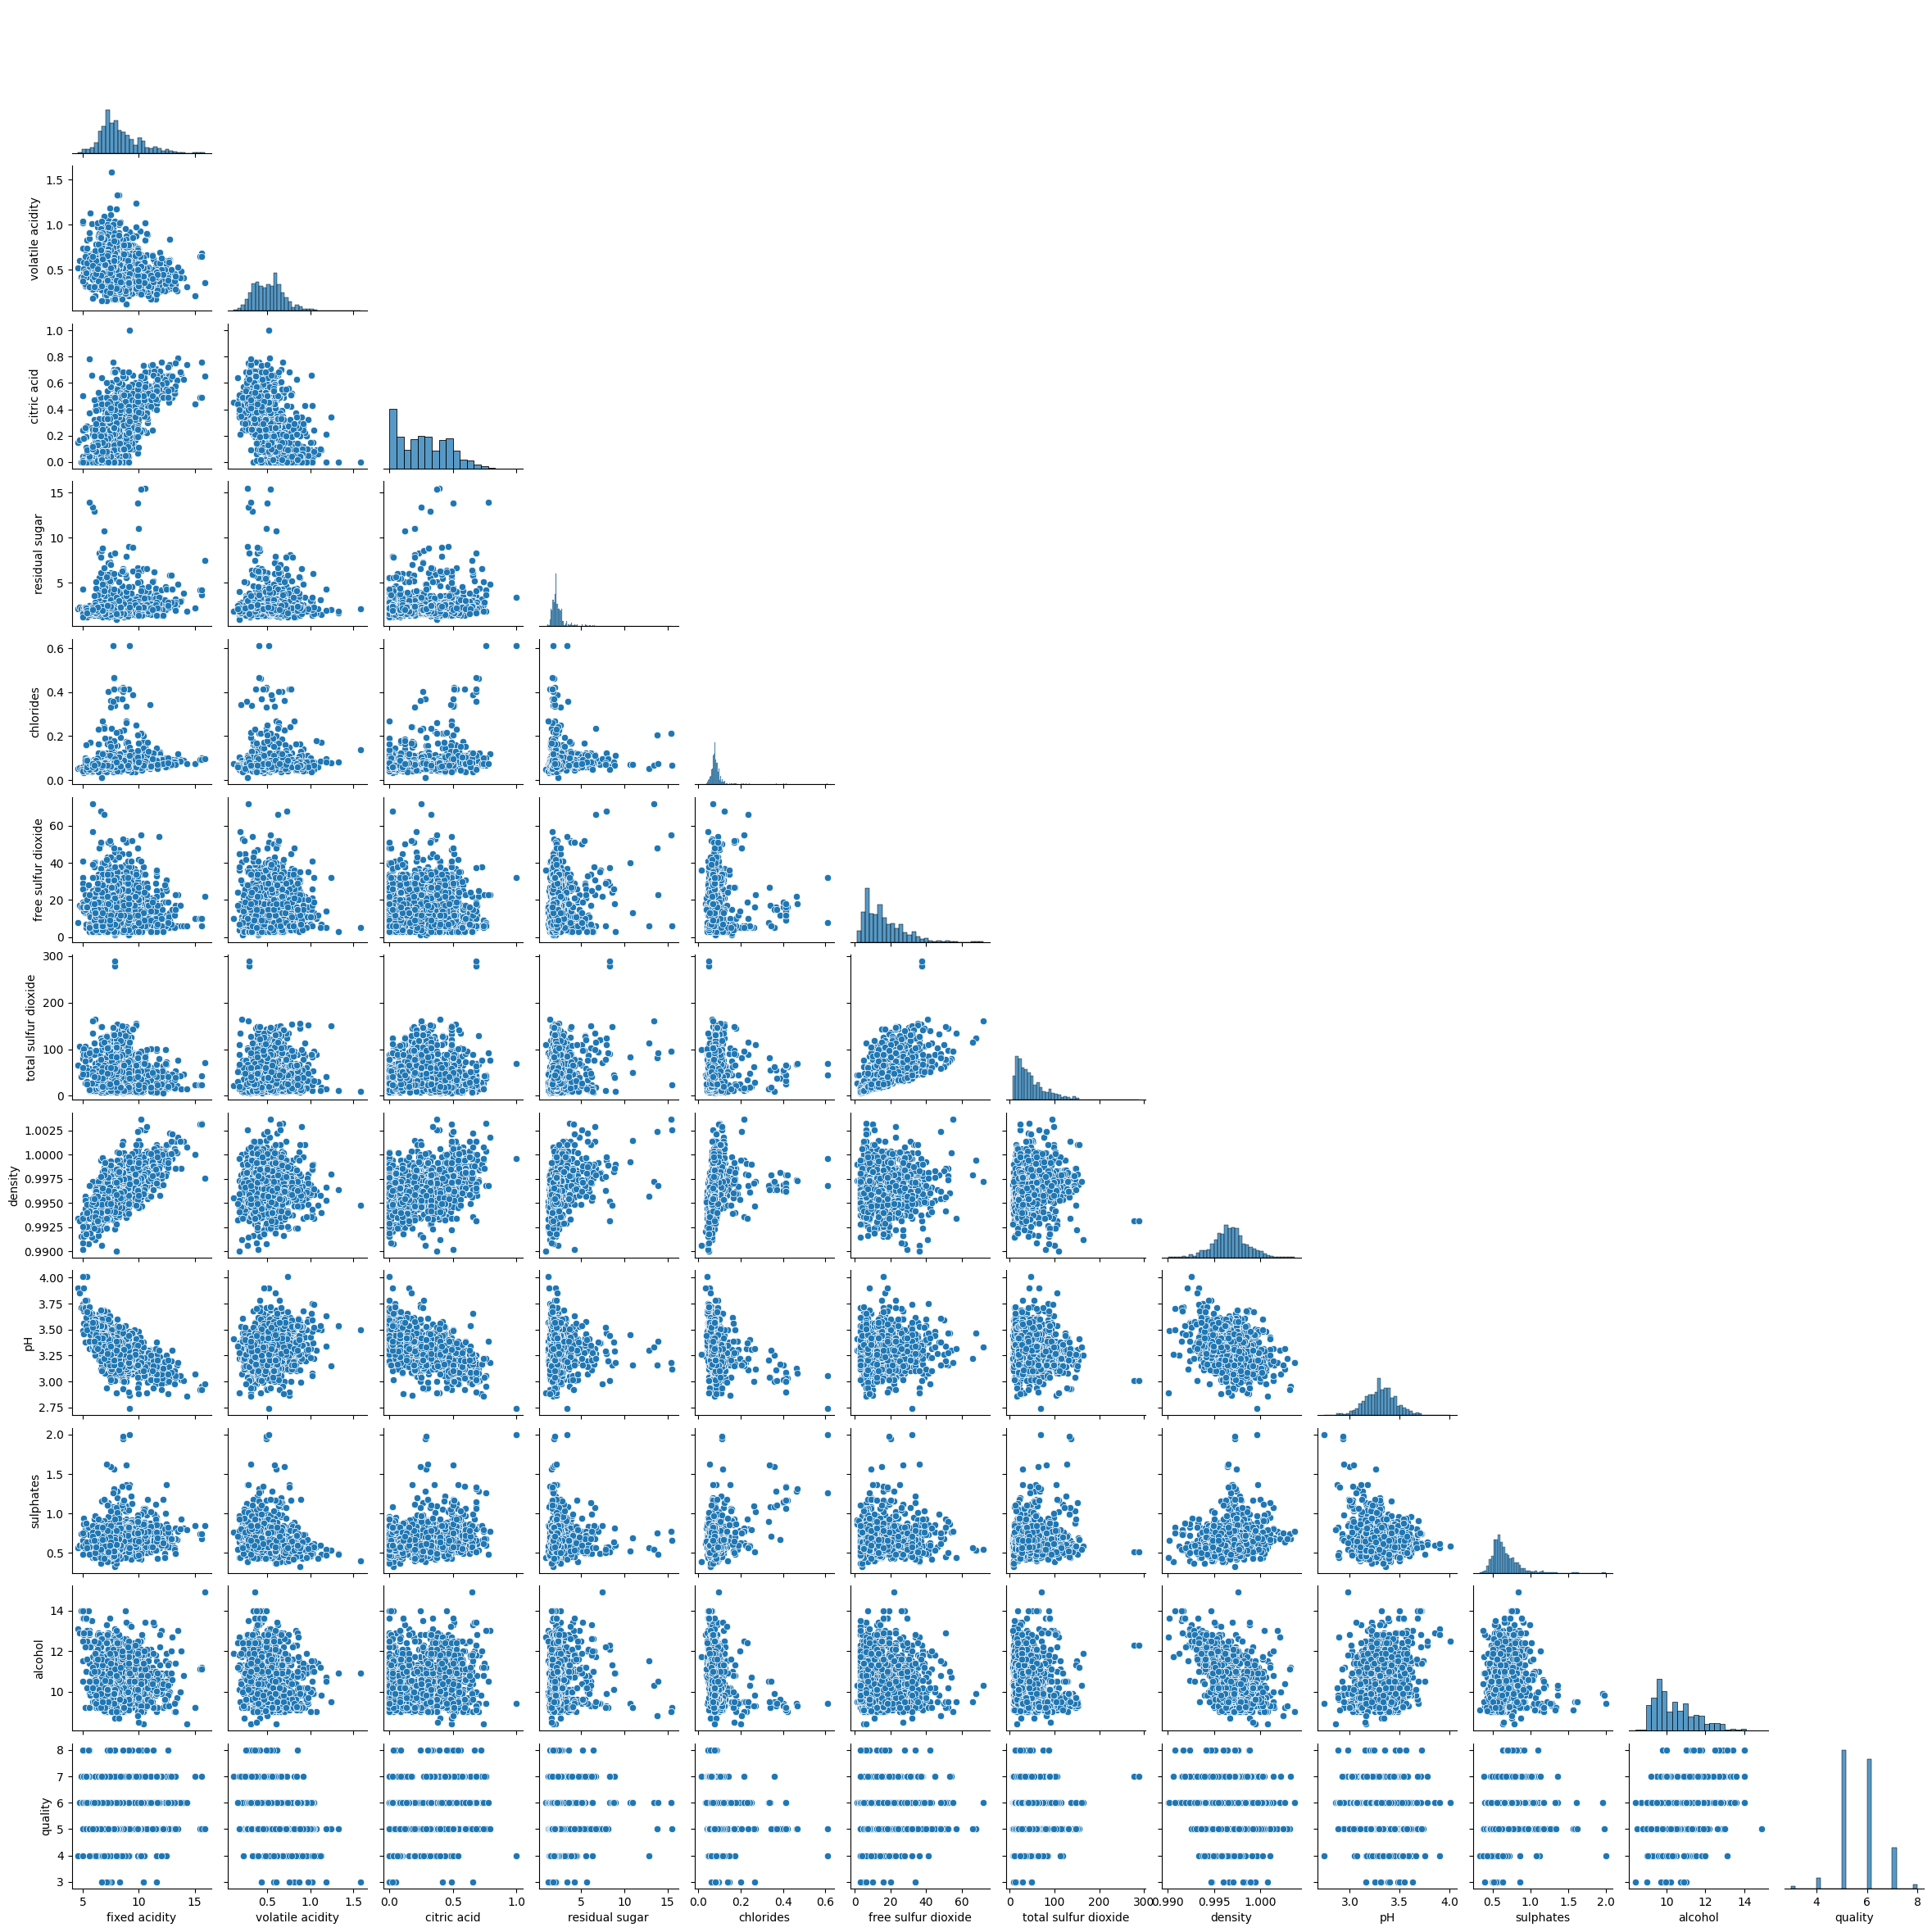

In [13]:
sns.pairplot(red_df, diag_kind='hist', height=2, aspect=1, corner=True)